In [65]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV 
import matplotlib.pyplot as plt

%matplotlib inline



In [9]:
churn = pd.read_csv('data/cleaned_churn.csv', index_col = 0)

In [12]:
churn['last_trip_date'] = pd.to_datetime(churn['last_trip_date'])
churn['signup_date'] = pd.to_datetime(churn['signup_date'])

In [60]:
earliest = churn['signup_date'].min().toordinal()
churn['signup_date'] = churn['signup_date'].apply(lambda x: x.toordinal() - earliest)

In [61]:
X = churn.drop(['last_trip_date', 'retention'], axis=1)
y = churn['retention']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [46]:
model = GradientBoostingClassifier(learning_rate = .1,
                                 n_estimators=100)

In [47]:
model.fit(X_train, y_train)
feat_imp = model.feature_importances_

In [48]:
yhat = model.predict(X_test)

In [49]:
yhat

array([ True, False,  True, ..., False, False,  True])

In [51]:
from sklearn.model_selection import cross_validate

scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall'}

scores = cross_validate(GradientBoostingClassifier(), X_train, y_train, scoring=scoring,
                         cv=10, return_train_score=True)
print(scores.keys())
print(np.mean(scores['test_acc'])) 
print(np.mean(scores['test_prec']))
print(np.mean(scores['test_rec']))

dict_keys(['fit_time', 'score_time', 'test_acc', 'train_acc', 'test_prec', 'train_prec', 'test_rec', 'train_rec'])
0.7886333333333333
0.7460465353175694
0.6620458679319889


In [31]:
for a, b in zip(X.columns, feat_imp):
    print(f"{a} : {b}")

avg_dist : 0.018007252677353636
avg_rating_by_driver : 0.22732149969624085
avg_rating_of_driver : 0.011906099882766138
avg_surge : 0.0043499868399234955
surge_pct : 0.1863985912999881
trips_in_first_30_days : 0.04401350413575053
luxury_car_user : 0.06908522816760335
weekday_pct : 0.16936555995377836
rating_by_driver? : 0.0008269753609271424
rating_of_driver? : 0.0007987614404506778
King's Landing : 0.1654351791912978
Winterfell : 0.014682716808935495
Android : 0.03762522016960844
iPhone : 0.05018342437537609


In [53]:
confusion_matrix(y_test, yhat)

array([[5366,  849],
       [1299, 2486]])

In [54]:
accuracy_score(y_test, yhat)

0.7852

In [55]:
recall_score(y_test, yhat)

0.6568031704095112

In [56]:
precision_score(y_test, yhat)

0.7454272863568215

In [58]:
retained = len(churn[churn['retention'] == True])
churned = len(churn[churn['retention'] == False])

In [59]:
retained / (retained + churned)

0.3758

In [ ]:
optimal_params = {'learning_rate': 0.15,
                'max_depth': 4,
                 'max_features': 'sqrt',
                 'min_samples_leaf': 1,
                 'n_estimators': 100,
                 'random_state': 1,
                     'subsample': 1}

In [67]:
gradient_boosting_grid = {'learning_rate': [.15],
                          'max_depth': [4],
                          'min_samples_leaf': [1],
                          'max_features': ['sqrt'],
                          'n_estimators': [100, 200, 300, 400, 500],
                          'random_state': [1]}
grid_seearch_boosted_cleaned = GridSearchCV(estimator=GradientBoostingClassifier(), 
                                            n_jobs = -1,
                                            param_grid=gradient_boosting_grid, 
                                             cv=5, verbose=1, return_train_score=True)

In [70]:
final_model = GradientBoostingClassifier(learning_rate = 0.025, 
                                         max_depth = 4, 
                                         max_features =  'sqrt',
                                         min_samples_leaf = 1,
                                         n_estimators = 1000,
                                         random_state = 1)

In [71]:
final_model.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.025, max_depth=4,
                           max_features='sqrt', n_estimators=1000,
                           random_state=1)

In [72]:
final_model.feature_importances_

array([0.03383095, 0.1595977 , 0.02523574, 0.10615664, 0.01188515,
       0.10643239, 0.0712984 , 0.07189704, 0.14395926, 0.00114973,
       0.01201005, 0.15036351, 0.01469106, 0.05170625, 0.03978614])

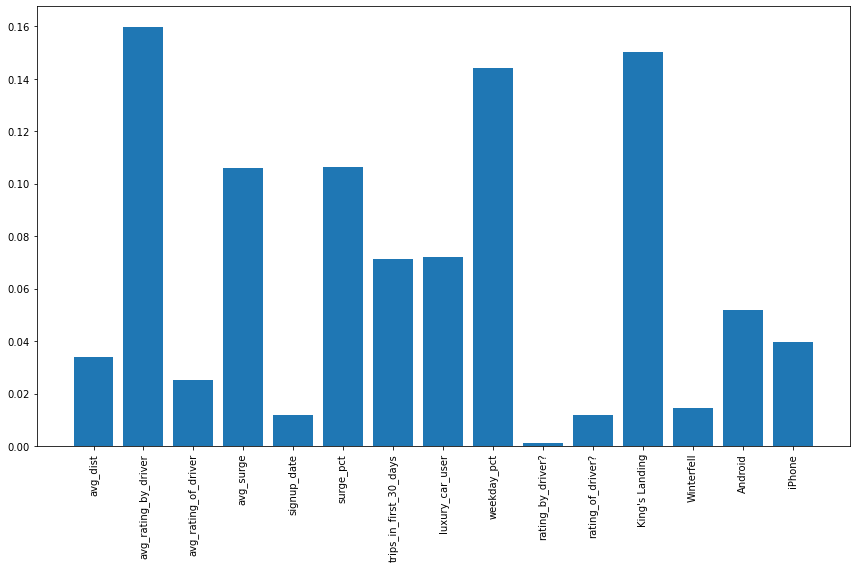

In [85]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(X_train.columns, final_model.feature_importances_)
ax.set_xticks(range(len(X_train.columns)))
ax.set_xticklabels([col for col in X_train.columns], rotation = 90)
fig.tight_layout()